### Part 1: Retrieval-Augmented Generation (RAG) Model for QA Bot


#### Problem Statement:
Develop a Retrieval-Augmented Generation (RAG) model for a Question Answering (QA)
bot for a business. Use a vector database like Pinecone DB and a generative model like
Cohere API (or any other available alternative). The QA bot should be able to retrieve
relevant information from a dataset and generate coherent answers.

### Pipeline

**Model Architecture** 

1. **Document Ingestion and Preprocessing**:

- Users upload PDF documents, which are read using PyPDF2 to extract text.
- The extracted text is split into smaller chunks using LangChain’s RecursiveCharacterTextSplitter to ensure better performance and efficient embedding of the text chunks.

2. **Embeddings**:

- HuggingFace's sentence-transformers/all-MiniLM-L6-v2 is used to generate dense vector representations (embeddings) for the document chunks.
- These embeddings are stored in Pinecone, a vector database optimized for fast similarity search using cosine similarity.
3. **Pinecone Integration**:

- If an index in Pinecone with the specified name doesn’t exist, the app creates one with a dimensionality of 384 (the output dimension of the MiniLM embedding model) and cosine similarity as the distance metric.
- The embedding chunks are upserted into the Pinecone vector store.

4. **Retrieval and Generative Response**:

- The vector store (Pinecone) serves as the knowledge base where relevant chunks are retrieved based on user queries.
- A ConversationalRetrievalChain is created using Cohere’s LLM (command-r-plus) and Pinecone’s retriever, ensuring responses are based on both current and previous questions (enabling contextual continuity in conversations).
- The application uses LangChain’s Memory Buffer to manage conversational history, maintaining the flow of the dialogue between the user and the syste

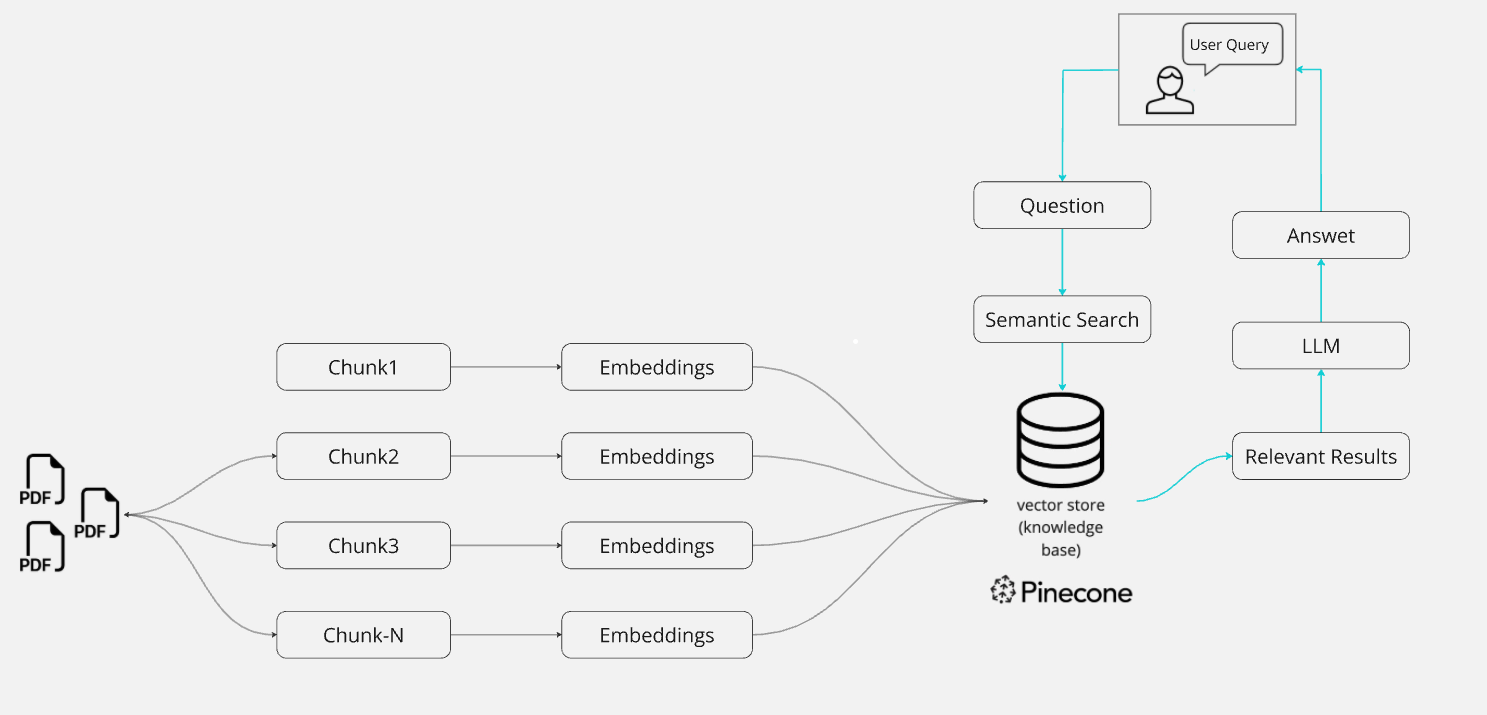

### Installing the required Libraries

In [1]:
%%writefile requirements.txt
unstructured
tiktoken
pinecone-client
pinecone
pypdf
openai
langchain
pandas
numpy
python-dotenv
accelerate
transformers
langchain-huggingface
langchain_cohere

Overwriting requirements.txt


In [2]:
!pip install -r requirements.txt

   ---------------------------------------- 0.0/419.8 kB ? eta -:--:--
    --------------------------------------- 10.2/419.8 kB ? eta -:--:--
   -- ------------------------------------ 30.7/419.8 kB 330.3 kB/s eta 0:00:02
   --- ----------------------------------- 41.0/419.8 kB 281.8 kB/s eta 0:00:02
   -------- ------------------------------ 92.2/419.8 kB 585.1 kB/s eta 0:00:01
   ---------- --------------------------- 112.6/419.8 kB 547.6 kB/s eta 0:00:01
   ----------------- -------------------- 194.6/419.8 kB 737.3 kB/s eta 0:00:01
   ------------------ ------------------- 204.8/419.8 kB 734.2 kB/s eta 0:00:01
   ------------------------- ------------ 276.5/419.8 kB 741.6 kB/s eta 0:00:01
   ----------------------------- -------- 327.7/419.8 kB 781.9 kB/s eta 0:00:01
   ----------------------------- -------- 327.7/419.8 kB 781.9 kB/s eta 0:00:01
   ----------------------------------- -- 389.1/419.8 kB 782.8 kB/s eta 0:00:01
   -------------------------------------- 419.8/419.8 kB 

### Importing the required libraries

In [12]:
import os
import sys


from dotenv import load_dotenv
load_dotenv()


import langchain
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from pinecone import Pinecone
from langchain_pinecone import PineconeVectorStore
from langchain.chains import RetrievalQA  
from langchain_cohere import ChatCohere
from pinecone import Pinecone, ServerlessSpec



from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate

### Loading and Chunking the document

In [2]:
loader = PyPDFLoader("E:/Project/SampleSet/Vision Transformer.pdf")
data = loader.load()
data[:500]

[Document(metadata={'source': 'E:/Project/SampleSet/Vision Transformer.pdf', 'page': 0}, page_content='Published as a conference paper at ICLR 2021\nANIMAGE IS WORTH 16X16 W ORDS :\nTRANSFORMERS FOR IMAGE RECOGNITION AT SCALE\nAlexey Dosovitskiy∗,†, Lucas Beyer∗, Alexander Kolesnikov∗, Dirk Weissenborn∗,\nXiaohua Zhai∗, Thomas Unterthiner, Mostafa Dehghani, Matthias Minderer,\nGeorg Heigold, Sylvain Gelly, Jakob Uszkoreit, Neil Houlsby∗,†\n∗equal technical contribution,†equal advising\nGoogle Research, Brain Team\n{adosovitskiy, neilhoulsby }@google.com\nABSTRACT\nWhile the Transformer architecture has become the de-facto standard for natural\nlanguage processing tasks, its applications to computer vision remain limited. In\nvision, attention is either applied in conjunction with convolutional networks, or\nused to replace certain components of convolutional networks while keeping their\noverall structure in place. We show that this reliance on CNNs is not necessary\nand a pure transfo

#### Creating the chunks of data

In [3]:
def chunk_data(document, chunk_size ,chunk_overlap):
    text_splitter = RecursiveCharacterTextSplitter(separators=['\n',','], chunk_size = chunk_size, chunk_overlap = chunk_overlap)
    doc = text_splitter.split_documents(document)
    return doc


docs = chunk_data(data, chunk_size=800, chunk_overlap=50)
len(docs)


99

### Creating the Embeddings and storing in vectorstores

#### Embedding model from hugging face

In [4]:
embedding_model =  HuggingFaceEmbeddings(model_name = "sentence-transformers/all-MiniLM-L6-v2")
embedding_model

C:\Users\91888\AppData\Local\Temp\ipykernel_36220\4107265796.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model =  HuggingFaceEmbeddings(model_name = "sentence-transformers/all-MiniLM-L6-v2")


c:\Users\91888\anaconda3\envs\deeplearning\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


HuggingFaceEmbeddings(client=SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
), model_name='sentence-transformers/all-MiniLM-L6-v2', cache_folder=None, model_kwargs={}, encode_kwargs={}, multi_process=False, show_progress=False)

#### Creatign a pinecone database and storing the documents

In [6]:

pc = Pinecone(
        api_key=os.environ.get("PINECONE_API_KEY")
    )

# Define the index name
index_name = 'sampleset1'
# f indexname not found create it otherwise utilize the present one
if not pc.has_index(index_name):
    pc.create_index(
        name=index_name,
        dimension=384,
        metric='cosine',
        spec=ServerlessSpec(
            cloud='aws',
            region='us-east-1'
        )
    )

index_info = pc.describe_index(index_name)
print(index_info)


{'deletion_protection': 'disabled',
 'dimension': 384,
 'host': 'sampleset1-ix4mfpm.svc.aped-4627-b74a.pinecone.io',
 'metric': 'cosine',
 'name': 'sampleset1',
 'spec': {'serverless': {'cloud': 'aws', 'region': 'us-east-1'}},
 'status': {'ready': True, 'state': 'Ready'}}


In [7]:
vector_store = PineconeVectorStore(index=index_name, embedding=embedding_model)

In [8]:
# Embed each chunk and upsert the embeddings into your Pinecone index.
docsearch = PineconeVectorStore.from_documents(
    documents=docs,
    index_name = index_name,
    embedding=embedding_model
)

### Retriever and Generator

In [9]:
#Creating the retriever

retriever=docsearch.as_retriever()

In [11]:
#Creteing the LLM of Cohere

COHERE_API_KEY = os.environ["COHERE_API_KEY"] 
llm = ChatCohere(model="command-r-plus")

In [13]:
# Initialize a LangChain object for chatting with the LLM with knowledge from Pinecone. 
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=docsearch.as_retriever()
)

#### Example queries 

In [32]:
query = 'Explain the working of ViT'

print(qa.invoke(query).get("result"))

ViT, or Vision Transformer, is a machine learning model that is used for processing and understanding visual data, such as images and videos. It is based on the Transformer architecture, which was originally designed for natural language processing tasks.

Here's a high-level overview of how ViT works:

1. Input: ViT takes an image as input, which is divided into a grid of fixed-size patches. Each patch is then flattened and projected to a fixed-dimensional vector. These vectors are referred to as patch embeddings.

2. Positionnal Encoding: To retain positional information about the patches, ViT adds positional encodings to the patch embeddings. This helps the model understand the spatial relationships between different parts of the image.

3. Transformer Encoder: The patch embeddings, along with their positional encodings, are then passed through a standard Transformer encoder, which is composed of multiple layers of multi-head self-attention and feedforward neural network layers. The

In [33]:
query = 'Tabulate the Various versions of ViT'

print(qa.invoke(query).get("result"))

| ViT Model | Resolution | # of Parameters |
| --- | --- | --- |
| ViT-L/16 | 14 | 1567 |
| ViT-H/14 | 14 | 4262 |
| ViT-B/32 | 7 | 106 |
| ViT-B/16 | 7 | 274 |
| ViT-L/32 | 7 | 246 |
| ViT-L/16 | 7 | 859 |
| ViT-L/16 | 14 | 1668 |


In [34]:
query = 'How the Positional Encoding is being carried out?'

print(qa.invoke(query).get("result"))

Positional encoding is carried out by adding a learned positional embedding to the inputs at the beginning of each layer. The positional embedding is shared between layers. There are two main ways of encoding positional information:

1. 1-dimensional positional embedding: The inputs are considered as a sequence of patches in the raster order.
2. 2-dimensional positional embedding: The inputs are considered as a grid of patches in two dimensions. In this case, two sets of embeddings (X-embedding and Y-embedding) are learned and concatenated based on the coordinate on the path in the input to create the final positional embedding for each patch.

The choice between 1-dimensional and 2-dimensional positional embedding does not seem to make a significant difference in performance, possibly because the Transformer encoder operates on patch-level inputs, which have smaller spatial dimensions than pixel-level inputs.


#### Creating the Q&A 

In [27]:

# 2. Incorporate the retriever into a question-answering chain.
system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)

question_answer_chain = create_stuff_documents_chain(llm, prompt)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)

#### Examples of Q&A

In [28]:
response1 = rag_chain.invoke({"input": "What is ViT?"})
response1["answer"]

'ViT stands for Vision Transformer.'

In [29]:
response2 = rag_chain.invoke({"input": "Summarize the whole documet"})
response2["answer"]

'The document discusses a ViT-H/14 model evaluated on the ObjectNet benchmark, with a focus on relative positional embeddings and attention maps. The model achieves 82.1% top-5 accuracy and 61.7% top-1 accuracy. It also mentions the use of Attention Rollout to compute attention maps and the increase in attention distance for all heads as the depth of the network increases.'

In [30]:
response3 = rag_chain.invoke({"input": "Explain the Architecture of ViT ?"})
response3["answer"]

'The Vision Transformer (ViT) is a large-scale transformer-based model for image classification. It divides images into patches, which are then processed by a standard transformer encoder. ViT models are more memory-efficient and use less compute than similar ResNets.'

In [31]:
response3 = rag_chain.invoke({"input": "Explain the Architecture of ViT ?"})
response3["answer"]

'ViT, or Vision Transformer, is a visual recognition model that uses self-attention to process images. It divides images into patches, which are then encoded and processed in a sequence. ViT models are more memory-efficient and have comparable speeds to ResNet models.'